# **Lab 3. Decision trees**
Here we will build a spam classification system by using an email dataset. Our goal is to develop optimal models to predict whether an email is spam or not spam based on word characteristics within each mail. We have to perform the following steps:
1. Prepare the dataset.
2. Find the optimal depth for the Decision Tree model and evaluate performance.
3. Fit the Bagging model using multiple bootstrapped datasets and enseble.
4. Fit a Random Forset model and evaluate performance.

## **1. Preparing the dataset**
As usal, let's start by setupping the necessary libraries and utilities.

In [155]:
import numpy as np
import pandas as pd 
import math 
import matplotlib
import matplotlib.pyplot as plt 
import sklearn.metrics as metrics 

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
from tqdm import tqdm 
from sklearn.model_selection import learning_curve

Then we create a dataframe `df` by invoking the `read_csv()` function from `pandas` library, specifying the correct dataset.

In [156]:
# Import dataset
df = pd.read_csv("dataset.csv")

### **1.1. Dataset labelling**
We also give a label for each column through the `columns` properties because the dataset is not labeled.

In [157]:
# Labels
columns = ['Column_'+str(i+1) for i in range(df.shape[1]-1)] + ['Spam']

# Dataset labelling
df.columns = columns

### **1.2. Dataset exploration**
Python allows us to intuitively visualize the structure of the dataframe using the `head()` function, which displays a snapshot of what's inside the dataset. The output of the `head()` function shows the first five rows of the dataset, along with the column names.

In [158]:
# Snapshot of the dataset
df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_49,Column_50,Column_51,Column_52,Column_53,Column_54,Column_55,Column_56,Column_57,Spam
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


Another way to explore the dataset is by using the `shape` property, which displays the number of rows and columns of the dataframe.

In [159]:
# Shape of the dataset
df.shape

(4600, 58)

We can see that our dataset is composed by 58 columns. The features of our problem are the columns `Column_i`, while the outcome is the last column `Spam`. We're dealing with a binary outcome which is 1 if the mail is spam, 0 if the mail is not spam.

### **1.3. Splitting data**
Once the dataset has been explored and well-understood, we need to split our data.

In our pipeline, there is a training phase during which we build our model and a test phase to test if the trained model performs well on completely independent examples, different from the ones used during training. This independent test helps us evaluate the model's generalization error.

Before splitting the original dataframe `df` into two new dataframes `df_train` and `df_test`, we fix a seed number in order to ensure the reproducibility of the code. Then, we generate an array `indx` of random numbers (distributed between 0 and 1) with the same length of the dataframe and then we convert it to a boolean array which values will be true for approximately the 70% of the samples.

In this way, we can split the dataset into training set and test set by considering, respectively, the true and false elements of the `indx` array.

In [160]:
# Fixed seed for reproducibility
np.random.seed(10)

# Boolean array
indx = np.random.rand(len(df)) < 0.7

We can now split the original `df` dataframe into two new dataframes: `df_train` for training and `df_test` for testing.

In [161]:
# Training set
df_train = df[indx]

# Test set
df_test = df[~indx]

To ensure that our dataset has been split correctly, we can use again the `head()` method to inspect the first few rows of `df_train`.

In [162]:
df_train.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_49,Column_50,Column_51,Column_52,Column_53,Column_54,Column_55,Column_56,Column_57,Spam
1,0.06,0.0,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.01,9.821,485,2259,1
2,0.00,0.0,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.00,3.537,40,191,1
4,0.00,0.0,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.00,3.000,15,54,1
5,0.00,0.0,0.00,0.0,1.92,0.00,0.00,0.00,0.00,0.64,...,0.00,0.054,0.0,0.164,0.054,0.00,1.671,4,112,1
6,0.00,0.0,0.00,0.0,1.88,0.00,0.00,1.88,0.00,0.00,...,0.00,0.206,0.0,0.000,0.000,0.00,2.450,11,49,1


### **1.4. Splitting features and outcomes**
After that, we separate the predictor features `Columns_i` from the response variables `Spam` in both the training set and test set.

In [163]:
# Splitting predictors and responses
x_train, y_train = df_train.drop(['Spam'], axis=1), df_train['Spam']
x_test, y_test = df_test.drop(['Spam'], axis=1), df_test['Spam']

We can check the percentage of spam in the training set and in the test set.

In [164]:
print('Percentage of Spam in training set:', str(round(100*y_train.sum()/len(y_train))) + '%')
print('Percentage of Spam in test set:', str(round(100*y_test.sum()/len(y_test))) + '%')

Percentage of Spam in training set: 38%
Percentage of Spam in test set: 42%


## **2. Training the decision tree model**

### **2.1. Tuning the depth of the tree**
Before training our decision tree model, it is useful to tune some hyperparameters. The hyperparameter we're interested in is the maximum depth of the tree. For this purpose, we initialize an empty dictionary `depth` in which we will store the cross-validation score obtained for different tree depths.

Then we set a range of values for the maximum depth of the tree by means of `tree_start` and `tree_end`.

By iterating the depth over this range, we create a decision tree model using the `DecisionTreeClassifier()` from `sklearn`.

For the current model we perform a 5-fold cross-validation over the training set and we compute the scores through the `cross_val_score()` function from `sklearn`. Finally, we store the average cross-validation score associated to the model with depth `i` in the dictionary.

In [165]:
# Empty dictionary
depth = {}

# Range of depths
tree_start, tree_end = 3, 30

# Tuning of the hyperparameter depth
for i in range (tree_start, tree_end):
    
    # Decision tree model
    model = DecisionTreeClassifier(max_depth = i)

    # Compute cross-validation scores
    scores = cross_val_score(estimator = model, X = x_train, y = y_train, cv = 5, n_jobs = 1)

    # Store the average score
    depth[i] = scores.mean()

After filling the dictionary with the average cross-validation scores, we sort its items and we unzip them in order to obtain two separate lists:
- `x`, in which will be stored the depths of the decision tree;
- `y` in which will be stored the average scores associated to the depths.

Then we compute the standard deviation of the cross-validation scores which can help us plot a measure related to the error.

In [166]:
# Sorting items of the dictionary
lists = sorted(depth.items())

# Unzipping items
x, y = zip(*lists)

# Measure of the error
y_err = scores.std()

### **2.2. Understanding cross-validation results**
The previous results can be used to plot the variation of the accuracy with respect to the depth of the decision tree model.

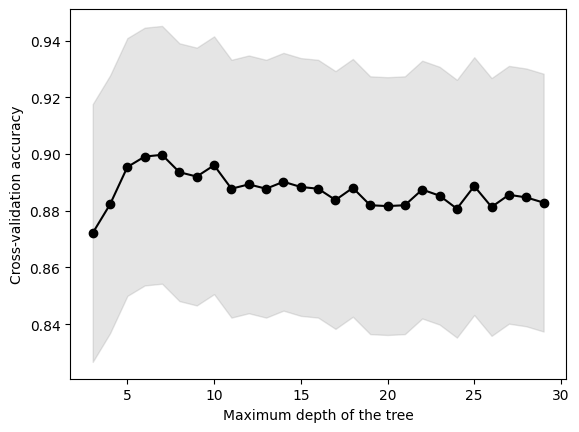

In [167]:
# Variation of the cross-validation accuracy
plt.plot(x, y, 'k-', marker='o')
plt.fill_between(x, y-y_err, y+y_err, color='grey', alpha=0.2)
plt.xlabel('Maximum depth of the tree')
plt.ylabel('Cross-validation accuracy')
plt.show()

This is a particular kind of plot because it not only shows how the average cross-validation score changes with respect to the different values of the maximum depth of the tree, but it also shows the so-called *shade curves* that can help us understand how the error is bounded into this area.

### **2.3. Choosing the best depth**
From the previous plot we can figure out that the best depth for the decision tree is a value between 5 and 10. To get the exact value of `best_depth`, we can sort the `depth` dictionary in descending order by the cross-validation score and then retrieve the element with the highest score.

In [168]:
# Finding the best depth
best_depth = sorted(depth, key=depth.get, reverse=True)[0]
print('The best depth is:', best_depth)

The best depth is: 7


As we expected, the best depth is a value between 5 and 10. 

### **2.4. Testing the best model**
Let us now evaluate the performance metrics related to the model with the best hyperparameter, on both the training and the test set.  First thing first, we initialize a new decision tree model by selecting the `best_depth` as the `max_depth` argument and then we fit the decision tree on training data through the `fit()` function from `sklearn`. In the same way we can compute the accuracies using the `accuracy_score()` function from `sklearn`.

Note that we use the function `predict()` to compute implicitly the predictions of the model on the training set and test set, respectively.


In [169]:
# Best model
model = DecisionTreeClassifier(max_depth = best_depth)

# Fitting model
model.fit(x_train, y_train)

# Checking accuracy of spam detection
acc_train = accuracy_score(y_train, model.predict(x_train)) 
acc_test = accuracy_score(y_test, model.predict(x_test))
print('Accuracy on the training set: {:.1%}'.format(acc_train))
print('Accuracy on the test set: {:.1%}'.format(acc_test))

Accuracy on the training set: 94.8%
Accuracy on the test set: 91.8%


As we can see that accuracies on the training set and on the test set are more or less the same, thus the model has not overfitted.

### **2.5. Performance metrics**
Accuracy metric is not enough to evaluate how well the model behaves. To take into account the classification performances of our decision tree model we can use the confusion matrix. We first need to define the `confusion_matrix` object by putting in relationship `y_test` with the predictions, computed once again using `model.predict()`. To display the confusion matrix we need to call `ConfusionMatrixDisplay()`.

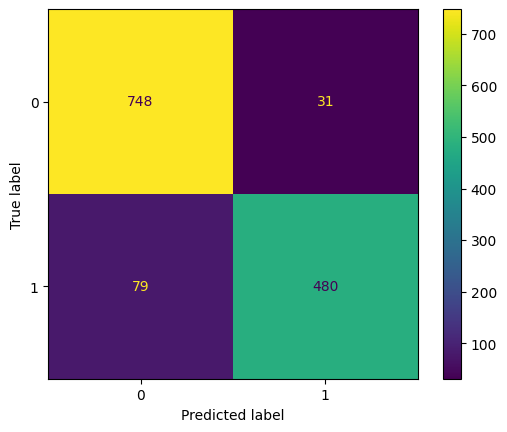

In [170]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, model.predict(x_test))

# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

If we want a tabular versione of the confusion matrix, we can use the function `crosstab()` from `pandas`. This version better shows the count of true negatives, true positives, false negatives and false positive instances. We can see that the false positives and false negatives instances are very low compared to the rest of the true positives and true negatives instances. That means our model is quite accurate in detecting spam!


In [171]:
# Alternative confusion matrix
pd.crosstab(y_test, model.predict(x_test), margins = True, rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1,All
Actual,,,
0,748,31,779
1,79,480,559
All,827,511,1338


Another way to evaluate the performances of our model is through the ROC cuve, which is a graphical representation of the trade-off between the true positives rate and the false positives rate. We need to extract the predicted probabilities for the positive class on the independent test.

Then we can compute the ROC AUC score using `roc_auc_score()` from `sklearn`. This metric provides us further information about the balance between sensitivity and specificity. Finally, we plot the ROC curve using `roc_curve()` from `sklearn`. It is useful to also plot a dashed line representing the chance level, where positive class and negative class have the same 50% probability, and a gray line representing the optimal case.

ROC AUC score: 0.9127671594011864


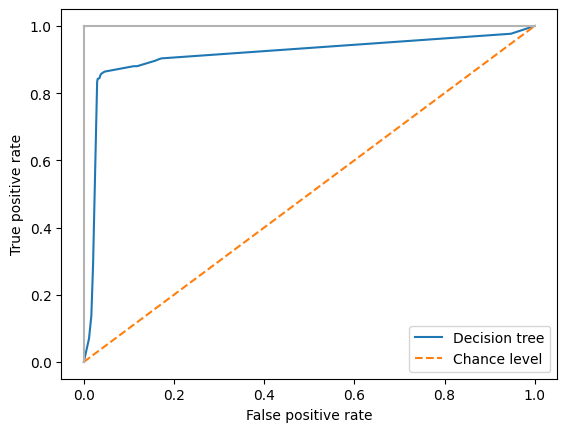

In [172]:
# Predicted probabilities for positive class
y_proba = model.predict_proba(x_test)[:,1]

# ROC AUC score
print('ROC AUC score:', roc_auc_score(y_test, y_proba, average = 'macro'))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label = 'Decision tree')
plt.plot([0,1], ls='--', label = 'Chance level')
plt.plot([0,0], [1,0], c = '0.7'), plt.plot([1,1], c = '0.7')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc = 'best')
plt.show()

## **3. Bagging model**
Let's make our model more complex. Bagging, also known as bootstrap aggregation, is an ensemble learning method that is commonly used to improve the stability and the accuracy of machine learning models. It also reduces variance and helps to avoid overfitting.

Given a standard training set $D$, bagging generates $n$ new training sets $D_i$ by sampling from $D$ uniformly and with replacement. This means that some of the observations within the initial training set $D$ may be repeated in each $D_i$. Then models are trained independently, one on each of the new training sets $D_i$, and their results are combined to a more accurate estimate. This means bagging implies an ensemble of decision trees.

### **3.1. Creating model**

Again, we fix a random seed for reproducibility and then we define a decision tree model with a maximum depth of 5.

In [173]:
# Fixed seed for reproducibility
np.random.seed(0)

# Decision tree model
model = DecisionTreeClassifier(max_depth = 5)

We want our ensable to be composed by 100 decision trees. For this purpose we define the variable `n_trees` which helps us to inizialize the arrays `predictions_train` and `predictions_test` to store the predictions of the ensable on both the training set and the test set.


In [174]:
# Number of trees in the ensemble
n_trees = 100

# Initialization of the predictions
predictions_train = np.zeros((df_train.shape[0], n_trees))
predictions_test = np.zeros((df_test.shape[0], n_trees))

### **3.2. Boostrapping**
We can start our bootstrapping process. In particular, we iterate over the specified number of trees in the ensamble to sample with  replacement the training set using the `sample()` function in order to obtain a boostrapped sample `temp_sample`. Then we extract the `Spam` outcome from the boostrapped sample and we save it in `response_variable`. We also drop the `Spam` outcome from the bootstrapped sample in order to properly fit the decision tre model. Finally, we store both the predictions on the training set and the test set.

In [175]:
# Bootstrapping
for i in range(n_trees):

    # Bootstrapped sample
    temp_sample = df_train.sample(frac = 1, replace = True)
    response_variable = temp_sample['Spam']
    temp_sample = temp_sample.drop(['Spam'], axis = 1)

    # Fitting model on bootstrapped sample
    model.fit(temp_sample, response_variable)

    # Computing predictions
    predictions_train[:,i] = model.predict(x_train)
    predictions_test[:,i] = model.predict(x_test)


Now we can build a prediction dataframe for the training set and a prediction dataframe for the test set by specifying the name of each column.

In [176]:
# Column names
columns = ['Bootstrap_model_' + str(i+1) for i in range(n_trees)]

# Predictions dataframes
predictions_train = pd.DataFrame(predictions_train, columns = columns)
predictions_test = pd.DataFrame(predictions_test, columns = columns)

To ensure that our boostrapping process worked fine, we can use the `head()` method to inspect the first few rows of `predictions_train`.

In [177]:
predictions_train.head()

,Bootstrap_model_1,Bootstrap_model_2,Bootstrap_model_3,Bootstrap_model_4,Bootstrap_model_5,Bootstrap_model_6,Bootstrap_model_7,Bootstrap_model_8,Bootstrap_model_9,Bootstrap_model_10,...,Bootstrap_model_91,Bootstrap_model_92,Bootstrap_model_93,Bootstrap_model_94,Bootstrap_model_95,Bootstrap_model_96,Bootstrap_model_97,Bootstrap_model_98,Bootstrap_model_99,Bootstrap_model_100
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we can see, `predictions_train` contains all the predictions for each bootstrapped decision tree model of the ensable.

### **3.3. Combining predictions**
Once each model has made its prediction, it is useful to visualize how the mean ensamble predictions are distributed for spam and not spam classes in both the training set and the test set. Histograms are a very intuitive tool to assess the separation of classes based on the ensamble's predictions.

First, we extract the target variable `Spam` from both the training set and the test set. Then we specify the number of trees `num_to_avg` which will be used to average in the ensamble. To compute the mean ensable predictions, we use `iloc()`. Finally we plot the histograms of the mean predictions for spam (1) and not spam (0) using two subplots, one for the training set and one for the test set. 

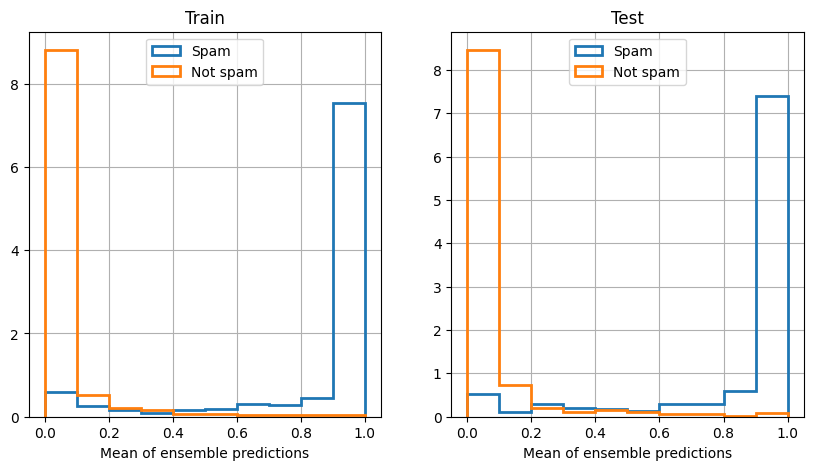

In [178]:
# Outcome vector
y_train = df_train['Spam'].values
y_test = df_test['Spam'].values

# Number of trees in the ensemble
num_to_avg = 100

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for (ax, label, predictions, y) in [
    (axs[0], 'Train', predictions_train, y_train),
    (axs[1], 'Test', predictions_test, y_test)
]:
    # Average ensemble predictions
    mean_predictions = predictions.iloc[:, :num_to_avg].mean(axis = 1)

    # Histograms
    mean_predictions[(y == 1)].hist(density = True, histtype = 'step', range = [0,1], label = 'Spam', lw = 2, ax = ax)
    mean_predictions[(y == 0)].hist(density = True, histtype = 'step', range = [0,1], label = 'Not spam', lw = 2, ax = ax)
    ax.legend(loc = 'upper center')
    ax.set_xlabel('Mean of ensemble predictions')
    ax.set_title(label)

Now we can define the function `get_prediction()` in order to ensamble the prediction of each bagged decision tree model.

This function will take the dataframe of the predictions `df` and the `count` parameter as inputs. If not specified, `count` will be set to the number of columns of the dataframe. Then we define a `temp` variable that extracts the first `count` columns from the dataframe in order to return a boolean array that thells whether the majority of the ensamble predictions is greater than 0.5 (which is the threshold for a binary classification task) or not.

In [179]:
# Ensambling predictions
def get_prediction(df, count=-1):

    # Number of trees
    count = df.shape[1] if count==-1 else count

    # Temp variable
    temp = df.iloc[:, 0:count]

    return np.mean(temp, axis = 1) > 0.5 

### **3.4. Performance metrics**
Now we can assess all the information about the performances of our spam detection tool on the independent set.

In [180]:
# Performance metrics
accuracy = metrics.accuracy_score(y_test, get_prediction(predictions_test, count=-1))
sensitivity = metrics.recall_score(y_test, get_prediction(predictions_test, count=-1))
specificity = metrics.recall_score(y_test, get_prediction(predictions_test, count=-1), pos_label = 0)
f1_score = metrics.f1_score(y_test, get_prediction(predictions_test, count=-1))

print('Accuracy:', accuracy)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('F1 score:', f1_score)

Accuracy: 0.9252615844544095
Sensitivity: 0.8658318425760286
Specificity: 0.9679075738125802
F1 score: 0.9063670411985019


By looking at the final scores we can see that they are very high! In particular, F1 score is very close to the accuracy, meaning that our model is balanced with respect to both positive and negative classes. Again, we can assess the behaviour of the model in terms of true positives, true negatives, false positives and false negatives instances by inspecting the confusion matrix.

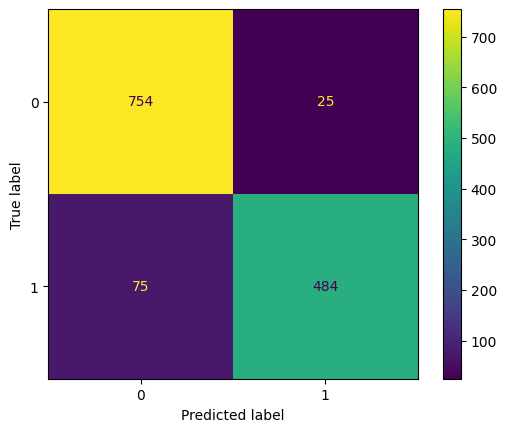

In [181]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, get_prediction(predictions_test, count=-1))

# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

## **4. Fitting a random forest model**
As a final step, we are interested in fitting a random forest model that introduces further randomness. We use the `RandomForestClassifier()` function from `sklearn` to declare our random forest model with a maximum depth set to the best value found for our decision tree.

As a rule of thumb, we set the number of estimators to the square root of the number of features.

In [182]:
# Random forest model
model = RandomForestClassifier(n_estimators = int(math.sqrt(x_train.shape[1])), max_depth = best_depth)

### **4.1. Fitting the model**
Then we fit the model on the training set and we predict the outcome for both the training set and the test set.

In [183]:
# Fitting the model
model.fit(x_train, y_train)

# Predictions
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

### **4.2. Performance metrics**
To check the generalization capabilities of our random forest model we have to assess the scores over the training set and the test set.

In [184]:
# Performance metrics
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)

print('Accuracy on the training set: {:.1%}'.format(train_score))
print('Accuracy on the test set: {:.1%}'.format(test_score))

Accuracy on the training set: 94.3%
Accuracy on the test set: 93.1%


We can see that the accuracy scores are relatable and have further increased.

### **4.3. Evaluating features importance**
By using random forests we can evaluate the relative importance of the features in the training of the model through the gini index or the entropy. We can retrieve the feature importance using the attribute `feature_importances_` of our trained model. Then we scale the importances in order to express them as a percentage. In this way, the most important feature will have 100% importance. Finally, we sort the features by their importance.

In [185]:
# Retrieving features importance
feature_importance = model.feature_importances_

# Scaling features importance
feature_importance = 100.0 * (feature_importance/feature_importance.max())

# Sorting features by their importance
sorted_idx = np.argsort(feature_importance)

We can plot the features by their importance using a barplot.

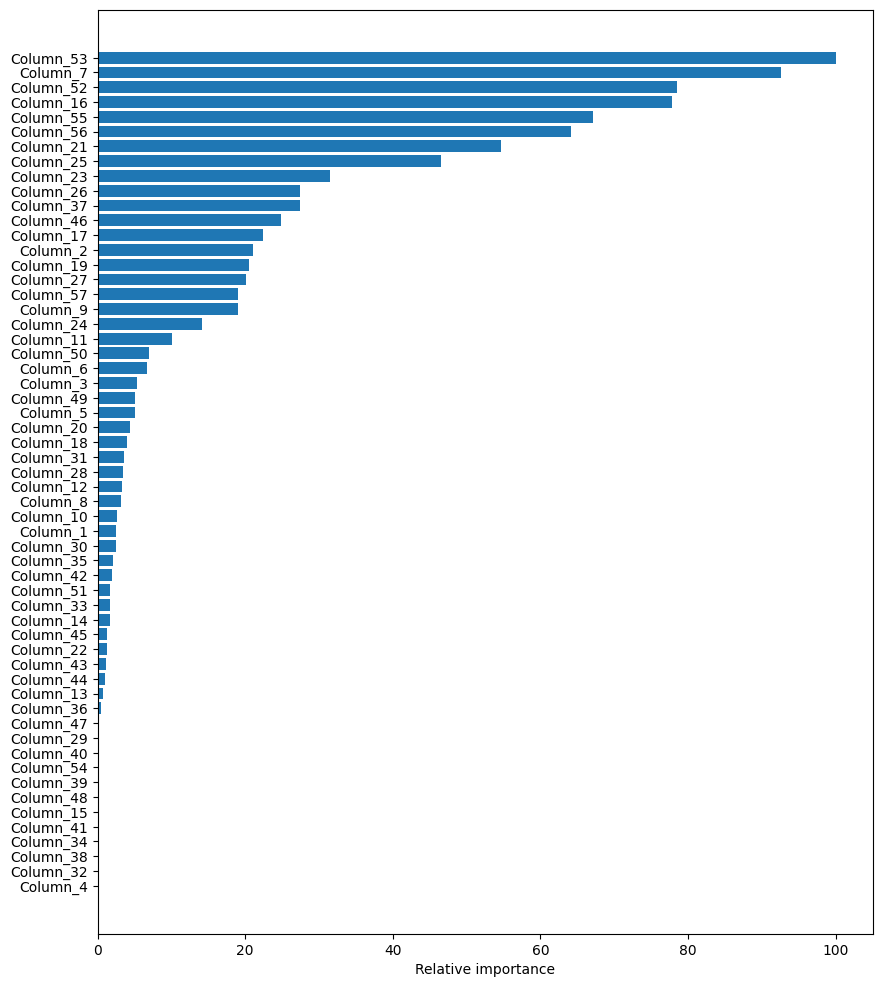

In [186]:
# Plot
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize = (10, 12))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative importance')
plt.show()

We can state that `Column_53` is the most important feature.

### **4.4. Learning curves**
It is very interesting to inspect how the training process of our random forest model changes with respect to the number of samples.

We can initialize a random forest model just like in the previous case. Then we use the `learing_curve()` function from `sklearn` to generate the cross-validation scores `train_scores` and `test_scores` for different training set sizes `train_sizes`.

In [187]:
# Random forest model
estimator = RandomForestClassifier(n_estimators = int(math.sqrt(x_train.shape[1])), max_depth = best_depth)

# Learning curves
train_sizes, train_scores, test_scores = learning_curve(estimator, x_train, y_train, cv = 5, scoring = 'accuracy', train_sizes = np.linspace(0.01, 1.0, 50))

Then we can compute the mean and the standard deviation of the training score and the test score. In this way we can not only plot the training score and the test score with respect to the number of samples in the training set, but also the corresponding shading curves.

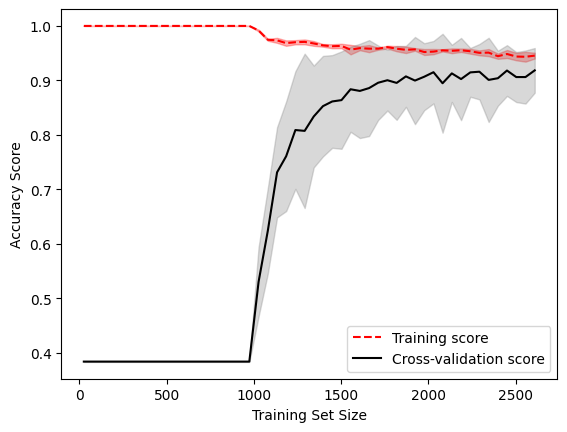

In [188]:
# Mean of the scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Standard deviation of the scores
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting learning curves
plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
plt.plot(train_sizes, test_mean, color="black", label="Cross-validation score")

# Plotting shade curves
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="red", alpha=0.3)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="gray",alpha=0.3)
plt.xlabel('Training Set Size'), plt.ylabel('Accuracy Score'), plt.legend(loc='best')
plt.show()

### **4.5. Understanding results**
Finally, we can understand the relationship between the training score and the cross-validation score (or test score). When assessing the relationship between the training set size and the model accuracy, we typically expect the training score to show very low variance, meaning it remains consistent as we use different subsets of the dataset. This low variance is crucial because it shows that the model performs reliably on the training set. 

As we increase the size of the training set to a substantial number, such as 1000 samples, it is essential to evaluate also the test score. We aim for the test score to align with that of the training score. This alignment means that the model performance on unseen data is becoming more consistent, reflecting good generalization. Initially, with a small number of training samples, the model tends to overfit, performing exceptionally well on the training set but poorly on the test set due to its focus on the specifics of the small training set. However, as we increase the number of samples, the model learns to generalize better. Consequently, the performance on both the training set and the test set improves, with the test score becoming more similar to the training score. This improvement continues until we reach an optimal sample size, where the scores stabilizes, indicating that the model no longer overfits and achieves better overall performance.